In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error

In [3]:
#Loading datasets
cuisine = pd.read_csv('chefmozcuisine.csv')
user_profile = pd.read_csv('userprofile.csv')
ratings = pd.read_csv('rating_final.csv')
user_cuisine = pd.read_csv('usercuisine.csv')
user_cuisine
geo_places = pd.read_csv('geoplaces2.csv', encoding='latin1')
geo_places

,placeID,latitude,longitude,the_geom_meter,name,address,city,state,country,fax,...,alcohol,smoking_area,dress_code,accessibility,price,url,Rambience,franchise,area,other_services
0,134999,18.915421,-99.184871,0101000020957F000088568DE356715AC138C0A525FC46...,Kiku Cuernavaca,Revolucion,Cuernavaca,Morelos,Mexico,?,...,No_Alcohol_Served,none,informal,no_accessibility,medium,kikucuernavaca.com.mx,familiar,f,closed,none
1,132825,22.147392,-100.983092,0101000020957F00001AD016568C4858C1243261274BA5...,puesto de tacos,esquina santos degollado y leon guzman,s.l.p.,s.l.p.,mexico,?,...,No_Alcohol_Served,none,informal,completely,low,?,familiar,f,open,none
2,135106,22.149709,-100.976093,0101000020957F0000649D6F21634858C119AE9BF528A3...,El Rincón de San Francisco,Universidad 169,San Luis Potosi,San Luis Potosi,Mexico,?,...,Wine-Beer,only at bar,informal,partially,medium,?,familiar,f,open,none
3,132667,23.752697,-99.163359,0101000020957F00005D67BCDDED8157C1222A2DC8D84D...,little pizza Emilio Portes Gil,calle emilio portes gil,victoria,tamaulipas,?,?,...,No_Alcohol_Served,none,informal,completely,low,?,familiar,t,closed,none
4,132613,23.752903,-99.165076,0101000020957F00008EBA2D06DC8157C194E03B7B504E...,carnitas_mata,lic. Emilio portes gil,victoria,Tamaulipas,Mexico,?,...,No_Alcohol_Served,permitted,informal,completely,medium,?,familiar,t,closed,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,132866,22.141220,-100.931311,0101000020957F000013871838EC4A58C1B5DF74F8E396...,Chaires,Ricardo B. Anaya,San Luis Potosi,San Luis Potosi,Mexico,?,...,No_Alcohol_Served,not permitted,informal,completely,medium,?,familiar,f,closed,none
126,135072,22.149192,-101.002936,0101000020957F0000E7B79B1DB94758C1D29BC363D8AA...,Sushi Itto,Venustiano Carranza 1809 C Polanco,San Luis Potosi,SLP,Mexico,?,...,No_Alcohol_Served,none,informal,no_accessibility,medium,sushi-itto.com.mx,familiar,f,closed,none
127,135109,18.921785,-99.235350,0101000020957F0000A6BF695F136F5AC1DADF87B20556...,Paniroles,?,?,?,?,?,...,Wine-Beer,not permitted,informal,no_accessibility,medium,?,quiet,f,closed,Internet
128,135019,18.875011,-99.159422,0101000020957F0000B49B2E5C6E785AC12F9D58435241...,Restaurant Bar Coty y Pablo,Paseo de Las Fuentes 24 Pedregal de Las Fuentes,Jiutepec,Morelos,Mexico,?,...,No_Alcohol_Served,none,informal,completely,low,?,familiar,f,closed,none


In [4]:
user_profile.nunique()

userID              138
latitude            128
longitude           126
smoker                3
drink_level           3
dress_preference      5
ambience              4
transport             4
marital_status        4
hijos                 4
birth_year           21
interest              5
personality           4
religion              5
activity              5
color                 8
weight               49
budget                4
height               38
dtype: int64

In [5]:
cuisine.nunique()

placeID     769
Rcuisine     59
dtype: int64

In [6]:
user_cuisine.columns = ['userID', 'user_cuisine']
user_cuisine.nunique()

userID          138
user_cuisine    103
dtype: int64

In [7]:
ratings.nunique()

userID            138
placeID           130
rating              3
food_rating         3
service_rating      3
dtype: int64

In [8]:
#user_prof = pd.merge(user_cuisine, user_profile)
user_prof_ratings = pd.merge(user_profile, ratings, on='userID')
upf_cuisine = pd.merge(user_prof_ratings, cuisine, on='placeID', how='left')
#user_prof_ratings
df = upf_cuisine.merge(user_cuisine)
df.drop_duplicates(subset=['userID','placeID'],keep='first', inplace=True)
df

,userID,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,...,color,weight,budget,height,placeID,rating,food_rating,service_rating,Rcuisine,user_cuisine
0,U1001,22.139997,-100.978803,false,abstemious,informal,family,on foot,single,independent,...,black,69,medium,1.77,132830,1,1,1,NaN,American
1,U1001,22.139997,-100.978803,false,abstemious,informal,family,on foot,single,independent,...,black,69,medium,1.77,132825,2,2,1,Mexican,American
2,U1001,22.139997,-100.978803,false,abstemious,informal,family,on foot,single,independent,...,black,69,medium,1.77,135085,0,1,1,Fast_Food,American
3,U1001,22.139997,-100.978803,false,abstemious,informal,family,on foot,single,independent,...,black,69,medium,1.77,135040,1,1,1,NaN,American
4,U1001,22.139997,-100.978803,false,abstemious,informal,family,on foot,single,independent,...,black,69,medium,1.77,135039,1,1,1,Seafood,American
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4055,U1137,22.144803,-100.944623,false,social drinker,formal,family,public,single,independent,...,blue,72,low,1.78,135049,2,2,2,Seafood,Mexican
4056,U1137,22.144803,-100.944623,false,social drinker,formal,family,public,single,independent,...,blue,72,low,1.78,135075,2,2,2,Seafood,Mexican
4057,U1138,22.152884,-100.939663,false,social drinker,formal,friends,public,single,independent,...,blue,54,medium,1.55,132921,2,2,1,Bar,Pizzeria
4058,U1138,22.152884,-100.939663,false,social drinker,formal,friends,public,single,independent,...,blue,54,medium,1.55,132922,2,2,2,Cafeteria,Pizzeria


In [9]:
df.columns

Index(['userID', 'latitude', 'longitude', 'smoker', 'drink_level',
       'dress_preference', 'ambience', 'transport', 'marital_status', 'hijos',
       'birth_year', 'interest', 'personality', 'religion', 'activity',
       'color', 'weight', 'budget', 'height', 'placeID', 'rating',
       'food_rating', 'service_rating', 'Rcuisine', 'user_cuisine'],
      dtype='object')

In [10]:
df['smoker'].value_counts()

false    907
true     223
?         31
Name: smoker, dtype: int64

In [11]:
df['smoker'].value_counts()

false    907
true     223
?         31
Name: smoker, dtype: int64

In [13]:
#Assign random value to a missing one based on proportion of the population
def fill_missing_values(column_name):
    df[column_name].replace('?', np.nan, inplace=True)
    prob = list(df[column_name].value_counts(normalize=True).values)
    names = list(df[column_name].value_counts(normalize=True).index)
    nan_list = list(df[df[column_name].isna() == True].index)
    for i in nan_list:
        df[column_name][i] = np.random.choice(names, p=prob)
        
missing_list = ['smoker', 'dress_preference', 'ambience', 
                'transport','marital_status', 'hijos','activity',
               'budget', 'Rcuisine']

for i in missing_list:
    fill_missing_values(i)

C:\Users\khaiv\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
df['smoker'].value_counts()

false    936
true     225
Name: smoker, dtype: int64

In [15]:
#Change qualitative values to numeric values 
warnings.filterwarnings('ignore')
df['userID'] = df['userID'].str.slice(2)
def cat_to_numeric(column_name):
    df[column_name + '_cat'] = df[column_name].astype('category')
    df[column_name + '_cat'] = df[column_name + '_cat'].cat.codes
    
categorical_list = ['smoker', 'drink_level','dress_preference', 'ambience', 'transport', 
                    'marital_status', 'hijos', 'interest', 'personality', 
                    'religion', 'activity','color', 'budget', 'Rcuisine','user_cuisine']
for i in categorical_list:
    cat_to_numeric(i)

In [16]:
df.columns

Index(['userID', 'latitude', 'longitude', 'smoker', 'drink_level',
       'dress_preference', 'ambience', 'transport', 'marital_status', 'hijos',
       'birth_year', 'interest', 'personality', 'religion', 'activity',
       'color', 'weight', 'budget', 'height', 'placeID', 'rating',
       'food_rating', 'service_rating', 'Rcuisine', 'user_cuisine',
       'smoker_cat', 'drink_level_cat', 'dress_preference_cat', 'ambience_cat',
       'transport_cat', 'marital_status_cat', 'hijos_cat', 'interest_cat',
       'personality_cat', 'religion_cat', 'activity_cat', 'color_cat',
       'budget_cat', 'Rcuisine_cat', 'user_cuisine_cat'],
      dtype='object')

In [17]:
df_cat = df[['userID', 'latitude', 'longitude','weight', 'height', 'placeID', 'rating',
       'food_rating', 'service_rating', 'smoker_cat',
       'interest_cat', 'Rcuisine_cat', 'marital_status_cat', 'budget_cat',
       'personality_cat', 'drink_level_cat', 'dress_preference_cat',
       'ambience_cat', 'transport_cat', 'hijos_cat', 'religion_cat',
       'activity_cat', 'color_cat','user_cuisine_cat']]

df_cat

,userID,latitude,longitude,weight,height,placeID,rating,food_rating,service_rating,smoker_cat,...,personality_cat,drink_level_cat,dress_preference_cat,ambience_cat,transport_cat,hijos_cat,religion_cat,activity_cat,color_cat,user_cuisine_cat
0,001,22.139997,-100.978803,69,1.77,132830,1,1,1,0,...,3,0,2,0,1,1,4,1,0,1
1,001,22.139997,-100.978803,69,1.77,132825,2,2,1,0,...,3,0,2,0,1,1,4,1,0,1
2,001,22.139997,-100.978803,69,1.77,135085,0,1,1,0,...,3,0,2,0,1,1,4,1,0,1
3,001,22.139997,-100.978803,69,1.77,135040,1,1,1,0,...,3,0,2,0,1,1,4,1,0,1
4,001,22.139997,-100.978803,69,1.77,135039,1,1,1,0,...,3,0,2,0,1,1,4,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4055,137,22.144803,-100.944623,72,1.78,135049,2,2,2,0,...,1,2,1,0,2,1,0,1,1,18
4056,137,22.144803,-100.944623,72,1.78,135075,2,2,2,0,...,1,2,1,0,2,1,0,1,1,18
4057,138,22.152884,-100.939663,54,1.55,132921,2,2,1,0,...,3,2,1,1,2,1,4,1,1,21
4058,138,22.152884,-100.939663,54,1.55,132922,2,2,2,0,...,3,2,1,1,2,1,4,1,1,21


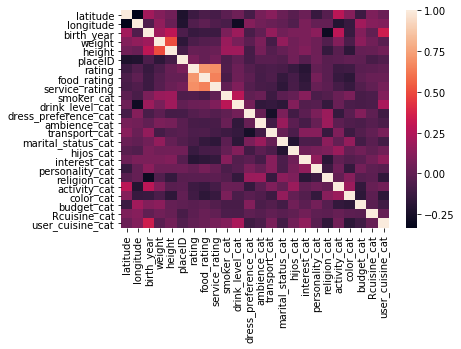

In [18]:
#Checking correlations of all the variables. No one variable is very good at predicting rating.
corr = df.corr()
_ = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

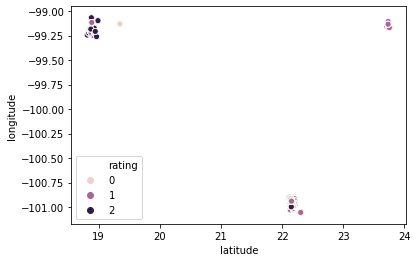

In [19]:
#Many of the higher rated restaurants cluster around the same area. 
sns.scatterplot(df.latitude, df.longitude, hue=df.rating)

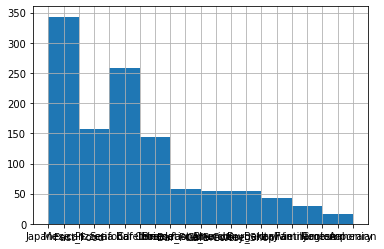

In [20]:
df['Rcuisine'].hist()

In [21]:
#Checking for normal distribution...
#Null hypothesis: The data is normally distributed
#Alternate hypothesis: The data is not normally distributed
chi_weight, p_weight = stats.chisquare(df.weight)
chi_height, p_height = stats.chisquare(df.height)
chi_cuisine, p_cuisine = stats.chisquare(df.Rcuisine_cat)

def check_distribution(p):
    if p < 0.05:
        print('The p-value of the chi-square test of the series is {}, therefore we reject the null hypothesis.'
              .format(p))
        print('The series is not normally distributed.')
    elif math.isnan(p) == True:
        print('Test is inconclusive.')
    else:
        print('The p-value of the chi-square test of the series is {}, therefore we fail to reject the null hypothesis.'
              .format(p))
        print('The series is normally distributed.')

check_distribution(p_weight)
check_distribution(p_height)
check_distribution(p_cuisine)


The p-value of the chi-square test of the series is 0.0, therefore we reject the null hypothesis.
The series is not normally distributed.
The p-value of the chi-square test of the series is 1.0, therefore we fail to reject the null hypothesis.
The series is normally distributed.
The p-value of the chi-square test of the series is 1.6806196225562702e-218, therefore we reject the null hypothesis.
The series is not normally distributed.


In [22]:
chi_log_weight, p_log_weight = stats.chisquare(np.log(df.weight))
check_distribution(p_log_weight)

The p-value of the chi-square test of the series is 1.0, therefore we fail to reject the null hypothesis.
The series is normally distributed.


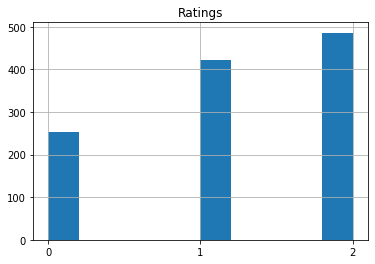

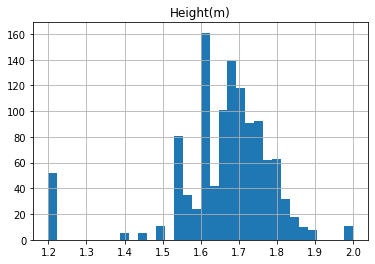

Text(0.5, 1.0, 'Weight(kg)')

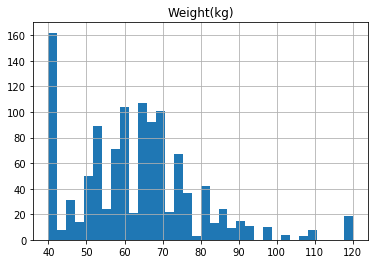

In [23]:
df['rating'].hist()
plt.xticks(np.arange(0, 3, step=1))
plt.title('Ratings')
plt.show()

df['height'].hist(bins=int(np.sqrt(len(df['height']))))
plt.title('Height(m)')
plt.show()

df.weight.hist(bins=int(np.sqrt(len(df['weight']))))
plt.title('Weight(kg)')

In [24]:
food_rating_ols = ols('Q("rating") ~ Q("food_rating")', df).fit()
food_rating_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Q("rating")   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     1211.
Date:                Tue, 04 Aug 2020   Prob (F-statistic):          2.89e-182
Time:                        17:59:12   Log-Likelihood:                -933.07
No. Observations:                1161   AIC:                             1870.
Df Residuals:                    1159   BIC:                             1880.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3519      0.029     12.101      0.000       0.295       0.409
Q("food_rating")     0.6977      0.020     34.803      0.000       0.658       0.737
==============================================================================
Omnibus:                       28.426   Durbin-Watson:                   1.674
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.538
Skew:                          -0.193   Prob(JB):                     4.76e-11
Kurtosis:                       3.913   Cond. No.                         3.65
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
serv_rating_ols = ols('Q("rating") ~ Q("service_rating")', df).fit()
serv_rating_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Q("rating")   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     1058.
Date:                Tue, 04 Aug 2020   Prob (F-statistic):          2.15e-165
Time:                        17:59:12   Log-Likelihood:                -971.96
No. Observations:                1161   AIC:                             1948.
Df Residuals:                    1159   BIC:                             1958.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.4633      0.028     16.564      0.000       0.408       0.518
Q("service_rating")     0.6754      0.021     32.522      0.000       0.635       0.716
==============================================================================
Omnibus:                       25.743   Durbin-Watson:                   1.612
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.357
Skew:                           0.241   Prob(JB):                     2.10e-08
Kurtosis:                       3.706   Cond. No.                         3.25
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
#Model to predict ratings based on other ratings
X = df_cat.drop(['rating', 'food_rating', 'service_rating'], axis=1)
y = df_cat['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print('R^2: {}'.format(rf_clf.score(X_test, y_test)))
print('Root Mean Squared Error: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

R^2: 0.5587392550143266
Root Mean Squared Error: 0.8258016856780858


In [50]:
#Tuning the model
parameters = {'max_depth': list(range(150,170)),
              'n_estimators': list(range(1,20)),
              'max_features': list(range(1,10))
                            
}

rf_clf_cv = GridSearchCV(rf_clf, parameters, cv=3)
rf_clf_cv.fit(X_train, y_train)
print('Tuned Random Forest Classification Parameters: {}'.format(rf_clf_cv.best_params_))
print('Best score is {}'.format(rf_clf_cv.best_score_))

Tuned Random Forest Classification Parameters: {'max_depth': 155, 'max_features': 6, 'n_estimators': 19}
Best score is 0.5808189655172413


In [51]:
#Testing on tuned model
print('R^2: {}'.format(rf_clf_cv.score(X_test, y_test)))
y_pred_cv = rf_clf_cv.predict(X_test)
rmse= np.sqrt(mean_squared_error(y_test, y_pred_cv))
print('Root Mean Squared Error: {}'.format(rmse))

R^2: 0.6223175965665236
Root Mean Squared Error: 0.6933157255384952


In [30]:
#Model to select most predictive variables
X = df_cat.drop(['rating', 'food_rating', 'service_rating'], axis=1)
y = df_cat['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
sel = SelectFromModel(RandomForestClassifier(n_estimators=100))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,
                                                 random_state=None, verbose=0,
  

In [31]:
#Selected variables
sel.get_support()
selected_feat = X_train.columns[(sel.get_support())]
print(selected_feat)

Index(['userID', 'latitude', 'longitude', 'height', 'placeID', 'Rcuisine_cat'], dtype='object')


In [32]:
X_2 = df[['userID', 'latitude', 'longitude', 'weight', 'height', 'placeID','Rcuisine_cat']]
y_2 = df['rating']
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.3, random_state=42)
model = RandomForestClassifier()
model.fit(X_2_train, y_2_train)
y_pred_2 = model.predict(X_2_test)
print(model.score(X_2_test, y_2_test))
print('Root Mean Squared Error: {}'.format(np.sqrt(np.mean(mean_squared_error(y_2_test,y_pred_2)))))

0.5759312320916905
Root Mean Squared Error: 0.8153259759086571


In [52]:
parameters = {'max_depth': list(range(150,170)),
              'n_estimators': list(range(40,50)),
              'max_features': list(range(1,7))
                            
}

model_cv = GridSearchCV(model, parameters, cv=3)
model_cv.fit(X_2_train, y_2_train)
print('Tuned Random Forest Classification Parameters: {}'.format(model_cv.best_params_))
print('Best score is {}'.format(model_cv.best_score_))

Tuned Random Forest Classification Parameters: {'max_depth': 153, 'max_features': 4, 'n_estimators': 45}
Best score is 0.5948275862068966


In [54]:
print('R^2: {}'.format(model_cv.score(X_2_test, y_2_test)))
y_pred_2_cv = model_cv.predict(X_2_test)
rmse= np.sqrt(mean_squared_error(y_2_test, y_pred_2_cv))
print('Root Mean Squared Error: {}'.format(rmse))

R^2: 0.6045845272206304
Root Mean Squared Error: 0.7532165980334


In [55]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_2_test, y_pred_2_cv)
cf_matrix

array([[ 44,  19,  14],
       [ 15,  64,  54],
       [  6,  30, 103]], dtype=int64)

In [45]:
log_reg = LogisticRegression()
log_reg.fit(X_2_train, y_2_train)
print('R^2: {}'.format(log_reg.score(X_2_test, y_2_test)))
y_pred_log = log_reg.predict(X_2_test)
rmse= np.sqrt(mean_squared_error(y_2_test, y_pred_log))
print('Root Mean Squared Error: {}'.format(rmse))

R^2: 0.38968481375358166
Root Mean Squared Error: 1.0692363983912534


In [47]:
cf_matrix = confusion_matrix(y_2_test, y_pred_log)
cf_matrix

array([[  0,  15,  62],
       [  0,  31, 102],
       [  0,  34, 105]], dtype=int64)

In [48]:
#Computes RMSE of system
def evaluate(estimate_f): 
    ids_to_estimate = zip(df_cat.userID, df_cat.placeID)
    estimated = np.array([estimate_f(u,i) for (u,i) in ids_to_estimate])
    real = df_cat.rating.values
    return np.sqrt(mean_squared_error(estimated, real))


In [49]:
#Collaborative system using implicit sims.
def pearson(s1, s2):
    s1_c = s1 - s1.mean()
    s2_c = s2 - s2.mean()
    return np.sum(s1_c * s2_c) / np.sqrt(np.sum(s1_c ** 2) * np.sum(s2_c ** 2))
class CollabReco:
    def learn(self):
        self.all_user_profiles = df_cat.pivot_table('rating', index='placeID', columns='userID')
    def estimate(self, userID, placeID):
        user_condition = df_cat.userID != userID
        place_condition = df_cat.placeID == placeID
        ratings_by_others = df_cat.loc[user_condition & place_condition]
        if ratings_by_others.empty: 
            return 3.0
        
        ratings_by_others.set_index('userID', inplace=True)
        their_ids = ratings_by_others.index
        their_ratings = ratings_by_others.rating
        their_profiles = self.all_user_profiles[their_ids]
        user_profile = self.all_user_profiles[userID]
        sims = their_profiles.apply(lambda profile: pearson(profile, user_profile), axis=0)
        ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
        ratings_sims = ratings_sims[ratings_sims.sim > 0]
        if ratings_sims.empty:
            return their_ratings.mean()
        else:
            return np.average(ratings_sims.rating, weights=ratings_sims.sim)
        
reco = CollabReco()
reco.learn()
print('RMSE for CollabReco: {}'.format(evaluate(reco.estimate)))

RMSE for CollabReco: 0.7194246980934265
